In [1]:
# Import built-in libraries
from pathlib import Path
import sys
import pandas as pd
import os
import yaml
import sys
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the project root directory
# project_root = Path("./").resolve().parent
project_root = Path("./").resolve().parent.parent


# Add the support_modules directory to Python's path
support_modules_path = os.path.join(project_root, 'src', 'support')
sys.path.append(support_modules_path)

# import customer moduels 
from AggregationModule import OWA, WA, WOWA, PiecewiseLinearInterpolator
from DataPreparation import ExecuteDataPreparation
from MappingModule import ExecuteDataMapping
# from ErrorMeasure import evaluate_WeightedMeanAbsoluteError
import WeightingModule
from DBConnectionModule import DBConnection

In [2]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config


def save_information(filename: str, information: str) -> None:
    """
    Save the given information to a text file.

    Args:
        filename (str): The name of the file to save the information in.
        information (str): The information to save.
    """
    with open(filename, 'w') as file:
        file.write(information)
    print(f"Information saved to {filename}")
    return None

In [3]:
filename_str = 'FairCOD-Dataset-v2.xlsx' # to be parametrized lately

In [4]:
input_dfs, criteria_list = ExecuteDataPreparation(filename = filename_str)

C:\Users\p.fronte\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [5]:
input_dfs

{23.3: {'Online Sales':           DPC                                          Epic_Name    CoD  \
  Epic_ID                                                                   
  LPM-246  23.3                              Online Sales guidance    5.0   
  LPM-288  23.3       Reservation Online for CUPRA Stock cars [UK]   13.0   
  LPM-131  23.3                    BtO Cash FR Online Agency (OVS)   40.0   
  LPM-161  23.3  Proactive support action to inactive leads in ...    5.0   
  LPM-136  23.3                    Stock Car Sales IT, FR, ES, UK   100.0   
  LPM-92   23.3                                       Closed types   13.0   
  LPM-133  23.3                      New conversion pannel (Stock)    8.0   
  LPM-245  23.3  Used Car Program adaptations – Maturity level ...   13.0   
  LPM-193  23.3   360º sales workplace - Remove dependencies fr...   13.0   
  LPM-195  23.3                        Maintenance backlog AU 2022    5.0   
  LPM-171  23.3                                  CUPRA

In [6]:
# load config files
weighting_config_path = os.path.join(project_root, 'src', 'config', 'Weighting_config.yaml')
db_config_path = os.path.join(project_root, 'src','config', 'DBConnectionModule_config.yaml')
weighting_config = load_config(weighting_config_path)
db_config = load_config(db_config_path)

In [7]:
# I load information about data source and aggregation strategy and processing config
filename_str = 'FairCOD-Dataset-v2.xlsx' # to be parametrized lately
aggregation = 'WOWA' # to be parametrized lately
save = True # to save results created as .csv files - to be parametrized lately

In [8]:
n = len(criteria_list)
# w vector -- apply strategy chosen
weighting_strategy = weighting_config[aggregation]['w']
w = WeightingModule.CreateWeightsArray(weighting_strategy, n)        
# p vector
p = weighting_config[aggregation]['p']

In [9]:
# preparing for processing
res_dict = {}
c_to_drop = ['DPC', 'Epic_Name', 'CoD', 'Backlog', 'Margin_to_deadline']

In [12]:
for dpc, backlogs in input_dfs.items():

    res_dict[dpc] = {}

    for backlog_name, df in backlogs.items():

        aggregated_df, aggregated_column_name = WOWA(dataframe=df, 
                                                        w_weights_vector=w,
                                                        p_weights_vector= p,
                                                        dpc=dpc,
                                                        columns_to_drop=c_to_drop)
        
        res_dict[dpc][backlog_name] = aggregated_df

KeyError: 'Unnamed: 63'

In [13]:
dataframe=df, 
w_weights_vector=w,
p_weights_vector= p,
dpc=dpc,
columns_to_drop=c_to_drop

In [15]:
aggregation_column_name = f'WOWA_{weighting_strategy}_{dpc}'

In [14]:
weighting_strategy = w.columns[0]
# setup name of new columns that will be created

In [16]:
# then converted into numpy array as before
w_weights_vector = np.round(w.to_numpy(), 3)

In [17]:
w_acc = [np.sum(w_weights_vector[0:i+1]) for i in range(len(w_weights_vector))]
w_acc.insert(0,0)

In [18]:
p_list = np.round(list(p.values()), 3) 
p_acc = [np.sum(p_list[0:i+1]) for i in range(len(p_list))]
p_acc.insert(0,0)

In [19]:
x_points = np.linspace(0,1,len(w_acc))

In [20]:
# Example usage
x_points = np.linspace(0,1,len(w_acc))
y_points = w_acc

In [21]:
trained_interpolator =PiecewiseLinearInterpolator(x_points, w_acc)

In [22]:
y_points

[0,
 0.395,
 0.654,
 0.8160000000000001,
 0.911,
 0.9620000000000001,
 0.9870000000000001,
 0.9970000000000001,
 1.0,
 1.001,
 1.001]

In [ ]:
# Set seaborn style
sns.set(style="white")  # Use a seaborn style of choice; whitegrid is good for line plots

# Create the plot with seaborn styling
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the main line
ax.plot(x_points, y_points, linewidth=5, color='b', label='Main Curve')

# Add dotted vertical lines from x-axis up to each y point
ax.vlines(x_points, ymin=0, ymax=y_points, linestyle='dotted', color="grey")

# Add dotted horizontal lines from y-axis to each x point
ax.hlines(y_points, xmin=0, xmax=x_points, linestyle='dotted', color="grey")

# Customize ticks and labels
ax.set_yticks([np.round(y, 3) for y in y_points])  # Set y-ticks based on y_points
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=17)

# Set labels, title, and margins
ax.set_ylabel('w vector (OWA-based) weights', fontsize=20, labelpad=15)
ax.set_xlabel('$p^0$ vector (WA-based) weights', fontsize=20, labelpad=50)
ax.set_title(r'$\omega^*$ interpolation function construction', fontsize=25, pad=20)
plt.margins(0, 0)  # Remove default margins
trans = ax.get_xaxis_transform()



for i in range(len(p_acc[:-1])):
    # plot the straight line corresponding to the p_sigma_i
    ax.plot([p_acc[i],p_acc[i+1]-0.005],
            [-.08,-.08], 
            color="k", 
            transform=trans, 
            clip_on=False)
    # plot the corresponding labels of the p_sigma_i
    ax.annotate(f'$p_\sigma{i}$', 
                xy=((p_acc[i]+p_acc[i+1])/2, -0.1), 
                xycoords=trans, 
                ha="center", 
                va="top",
                fontsize=15)

# plot the vertical lines p_sigma_i up to the intersection with
# interpolated function \omega*
for i in range(len(p_acc)):
    ax.vlines(p_acc[i], 
              ymin=0, 
              ymax=trained_interpolator.interpolate(p_acc[i]), 
              color="red",
              linewidth=3)

# plot the horizontal lines from \omega* to the end of the boxplot
# to highlight the position of the various \omega_i
for i in range(len(p_acc)):
    ax.hlines(trained_interpolator.interpolate(p_acc[i]), 
              xmin=p_acc[i], 
              xmax=1, 
              color="lightcoral",
              linewidth=2)

raw_omega_i = [trained_interpolator.interpolate(x) for x in p_acc]
yticks_omega_i = [f'w_{i}' for i in range(len(y_points))]
# Create a secondary y-axis on the right side with different tick positions
ax_right = ax.twinx()
right_y_ticks = raw_omega_i  # Define custom y-ticks for the right side
ax_right.set_yticks(raw_omega_i)
ax_right.set_yticklabels([f'{tick:.2f}' for tick in right_y_ticks], fontsize=17)  # Format right-side tick labels

# Optionally, set a label for the right y-axis (or leave it blank)
ax_right.set_ylabel('Alternative Scale', fontsize=20, labelpad=15)


# Show the plot
plt.show()

In [30]:
def plot_WOWA(w_vector, p_vector):


    w_weights_vector = np.round(w_vector.to_numpy(), 3)
    w_acc = [np.sum(w_weights_vector[0:i+1]) for i in range(len(w_weights_vector))]
    w_acc.insert(0,0)


    p_list = np.round(list(p_vector.values()), 3) 
    p_acc = [np.sum(p_list[0:i+1]) for i in range(len(p_list))]
    p_acc.insert(0,0)

    x_points = np.linspace(0,1,len(w_acc))
    y_points = w_acc    


    trained_interpolator =PiecewiseLinearInterpolator(x_points, w_acc)


    # Set seaborn style
    sns.set(style="white")  # Use a seaborn style of choice; whitegrid is good for line plots

    # Create the plot with seaborn styling
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the main line
    ax.plot(x_points, y_points, linewidth=5, color='b', label='Main Curve')

    # Add dotted vertical lines from x-axis up to each y point
    ax.vlines(x_points, ymin=0, ymax=y_points, linestyle='dotted', color="grey")

    # Add dotted horizontal lines from y-axis to each x point
    ax.hlines(y_points, xmin=0, xmax=x_points, linestyle='dotted', color="grey")

    # Customize ticks and labels
    ax.set_yticks([np.round(y, 3) for y in y_points])  # Set y-ticks based on y_points
    ax.tick_params(axis='y', labelsize=17)
    ax.tick_params(axis='x', labelsize=17)

    # Set labels, title, and margins
    ax.set_ylabel('w vector (OWA-based) weights', fontsize=20, labelpad=15)
    ax.set_xlabel('$p^0$ vector (WA-based) weights', fontsize=20, labelpad=50)
    ax.set_title(r'$\omega^*$ interpolation function construction', fontsize=25, pad=20)
    plt.margins(0, 0)  # Remove default margins
    trans = ax.get_xaxis_transform()



    for i in range(len(p_acc[:-1])):
        # plot the straight line corresponding to the p_sigma_i
        ax.plot([p_acc[i],p_acc[i+1]-0.005],
                [-.08,-.08], 
                color="k", 
                transform=trans, 
                clip_on=False)
        # plot the corresponding labels of the p_sigma_i
        ax.annotate(f'$p_\sigma{i}$', 
                    xy=((p_acc[i]+p_acc[i+1])/2, -0.1), 
                    xycoords=trans, 
                    ha="center", 
                    va="top",
                    fontsize=15)

    # plot the vertical lines p_sigma_i up to the intersection with
    # interpolated function \omega*
    for i in range(len(p_acc)):
        ax.vlines(p_acc[i], 
                  ymin=0, 
                  ymax=trained_interpolator.interpolate(p_acc[i]), 
                  color="red",
                  linewidth=3)

    # plot the horizontal lines from \omega* to the end of the boxplot
    # to highlight the position of the various \omega_i
    for i in range(len(p_acc)):
        ax.hlines(trained_interpolator.interpolate(p_acc[i]), 
                  xmin=p_acc[i], 
                  xmax=1, 
                  color="lightcoral",
                  linewidth=2)

    raw_omega_i = [trained_interpolator.interpolate(x) for x in p_acc]
    yticks_omega_i = [f'w_{i}' for i in range(len(y_points))]
    # Create a secondary y-axis on the right side with different tick positions
    ax_right = ax.twinx()
    right_y_ticks = raw_omega_i  # Define custom y-ticks for the right side
    ax_right.set_yticks(raw_omega_i)
    ax_right.set_yticklabels([f'{tick:.2f}' for tick in right_y_ticks], fontsize=17)  # Format right-side tick labels

    # Optionally, set a label for the right y-axis (or leave it blank)
    ax_right.set_ylabel('Alternative Scale', fontsize=20, labelpad=15)


    # Show the plot
    plt.show()

In [32]:
# OWA w

,RankExponent_4
0,0.394742
1,0.258990
2,0.161686
3,0.094778
4,0.051159
5,0.024671
6,0.010105
7,0.003197
8,0.000632
9,0.000039


In [33]:
p

{'EconomicImpact_Income': 0.181818182,
 'EconomicImpact_CostsSaving': 0.163636364,
 'Markets_Value': 0.145454545,
 'Critical_Event_value': 0.127272727,
 'CustomerSatisfaction_Value': 0.109090909,
 'EconomicImpact_LossPrevention': 0.090909091,
 'UserExperience_FutureCustomerExperience_Value': 0.072727273,
 'Margin_to_deadline_value': 0.054545455,
 'Strategy_Value': 0.036363636,
 'PlatformUsage_FinalValue': 0.018181818}

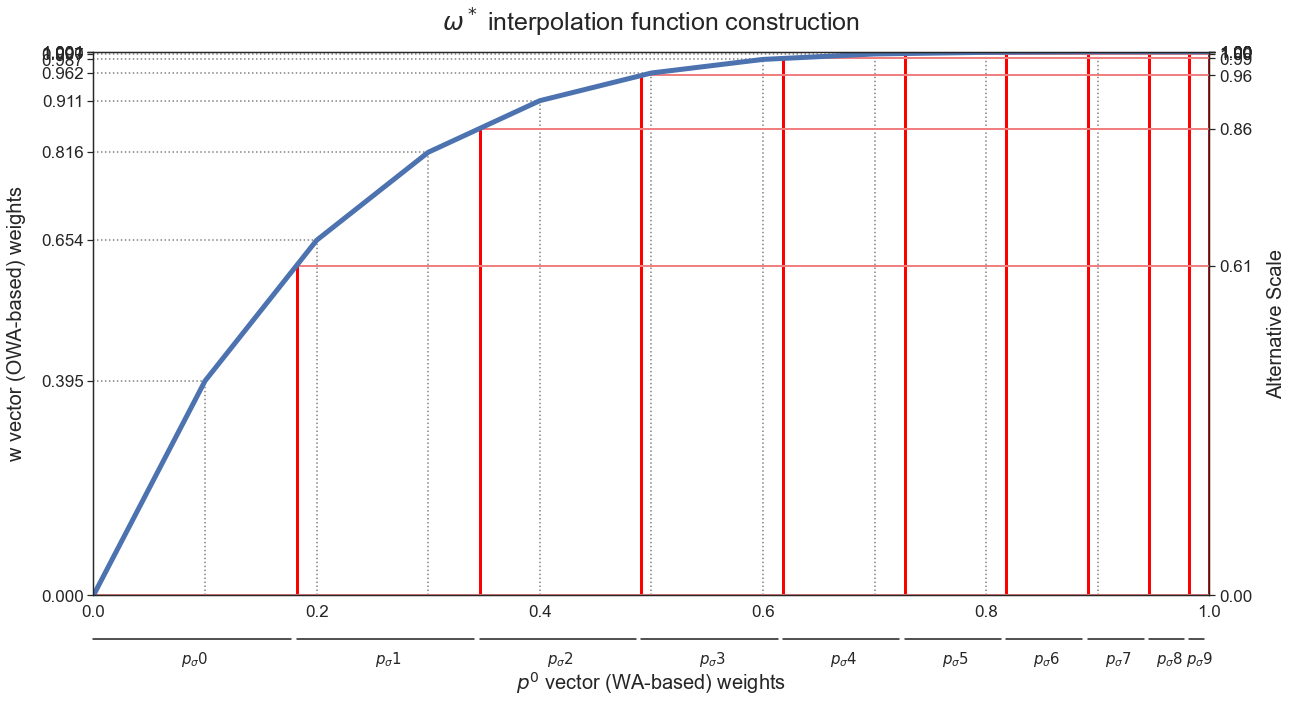

In [31]:
plot_WOWA(w_vector=w, p_vector=p)

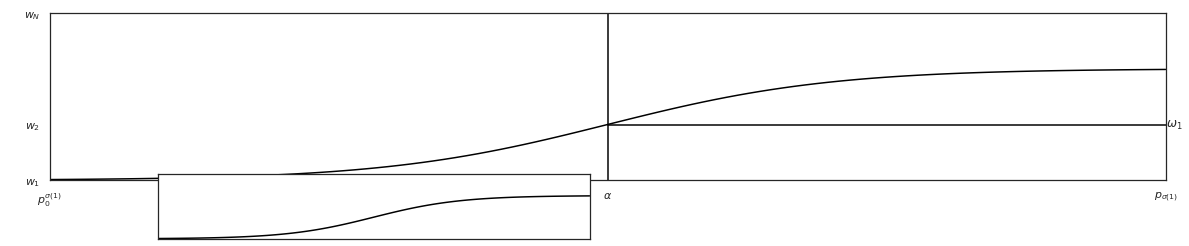

In [38]:
# Create the main figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Define a smooth curve (e.g., sigmoid-like or logistic function)
x = np.linspace(-5, 5, 100)
y = 1 / (1 + np.exp(-x))

# Plot the main curve
ax.plot(x, y, color='black')

# Set aspect ratio to make the main plot a square
ax.set_aspect(1)

# Define main square limits
ax.set_xlim(-5, 5)
ax.set_ylim(0, 1.5)

# Customize the ticks on the left and bottom to match the style in the original
ax.set_xticks([-5, -2.5, 0, 2.5, 5])
ax.set_xticklabels([r'$p_0^{\sigma(1)}$', '', r'$\alpha$', '', r'$p_{\sigma(1)}$'])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([r'$w_1$', r'$w_2$', '', r'$w_N$'])

# Draw the inset plot as a smaller square
inset_size = 0.3  # relative size of inset
inset = fig.add_axes([0.2, 0.2, inset_size, inset_size])  # position inset
inset.plot(x, y, color='black')
inset.set_xlim(-5, 5)
inset.set_ylim(0, 1.5)
inset.set_aspect(1)

# Hide ticks for a cleaner look
inset.set_xticks([])
inset.set_yticks([])

# Add annotations to main plot
ax.annotate(r'$\omega_1$', xy=(5, 0.5), va='center', ha='left')
ax.annotate(r'$w_1$', xy=(-5.3, 0.05), ha='center', va='center')
ax.annotate(r'$w_2$', xy=(-5.3, 0.5), ha='center', va='center')
ax.annotate(r'$w_N$', xy=(-5.3, 1.5), ha='center', va='center')

# Draw vertical and horizontal lines at specific points
ax.axvline(x=0, ymin=0, ymax=1, color='black')  # vertical line at alpha
ax.axhline(y=0.5, xmin=0.5, xmax=1, color='black')  # horizontal line at omega_1

# Ensure the main plot has a box around it, as in the original
for spine in ax.spines.values():
    spine.set_visible(True)

# Show the plot
plt.show()

In [39]:
# the trained interpolator is nothing but the interpolation function w* 
trained_interpolator = PiecewiseLinearInterpolator(x_points, y_points)

In [40]:
config = load_config(config_file_path)

NameError: name 'config_file_path' is not defined

In [ ]:
# Read and process the excel file
if os.path.exists(excel_file_path):
    
    # read the excel worksheet, if exists
    df = pd.read_excel(excel_file_path, sheet_name='Dataset', index_col='Epic_ID')
    df.convert_dtypes(convert_string=True)

c:\Users\TCXBQOI\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [ ]:
df

,DPC,Epic_Name,CoD,Effort,WSJF,Backlog,Status in D.P.O. for column DPC 23.3,In DPC prio for 23.3?,EconomicImpact_Income,EconomicImpact_CostsSaving,...,CustomerSatisfaction_L2SpecificPart,CustomerSatisfaction_L3Details,CustomerSatisfaction_L4MoreInfo,CustomerSatisfaction_Value,Critical_Event_type,Critical_Event_value,CarOwner_CarSegment,Deadline,Margin_to_deadline,Comments
Epic_ID,,,,,,,,,,,,,,,,,,,,,
LPM-246,23.3,Online Sales guidance,5.0,2.0,2.5,Online Sales,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,45077,NaN
LPM-288,23.3,Reservation Online for CUPRA Stock cars [UK],13.0,3.0,4.3,Online Sales,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,45077,NaN
LPM-215,23.3,AI assistant in website,8.0,2.0,4.0,Websites,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,45077,NaN
LPM-132,23.3,New homepage CUPRA,21.0,5.0,4.2,Websites,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,45077,NaN
LPM-128,23.3,New PHYGITAL product discovery experience for ...,40.0,8.0,5.0,Websites,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,45077,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LPM-308,24.3,PHEV Section: SEAT,13.0,2.0,6.5,Websites,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaT,45467,NaN
LPM-320,24.3,New PHYGITAL product discovery experience for ...,100.0,2.0,50.0,Websites,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Digital Platform unavailability,NaN,NaN,2024-09-02,70,NaN
LPM-332,24.3,Zenit comparator tool,5.0,3.0,1.6,Online Sales,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,45467,NaN


In [ ]:
clean_dataset_to_process = (df.pipe(DP.function_mapping_critical_event_to_value, config['mapping_critical_event_to_value']).
                            pipe(pd.DataFrame.replace, to_replace=np.NAN, value=0).
                            pipe(pd.DataFrame.drop, config['columns_to_drop'], axis=1).
                            pipe(DP.transform_Margin_to_deadline))

In [ ]:
clean_dataset_to_process.columns

Index(['DPC', 'Epic_Name', 'CoD', 'Backlog', 'EconomicImpact_Income',
       'EconomicImpact_CostsSaving', 'EconomicImpact_LossPrevention',
       'Strategy_Value', 'UserExperience_FutureCustomerExperience_Value',
       'PlatformUsage_FinalValue', 'Markets_Value',
       'CustomerSatisfaction_Value', 'Critical_Event_value',
       'Margin_to_deadline', 'Margin_to_deadline_value'],
      dtype='object')

In [ ]:
# ordered fullset criteria contains, indeed, the ordered criteria according to results of study 1
# the join with the columns list of the dataframe allows me to understand which subset of the ordered set
# will be actually adopted in the analysis
criteria_list = DP.join_lists_keep_order(config['ordered_fullset_criteria'], clean_dataset_to_process.columns.to_list())

print(criteria_list)

# Create a dictionary to store DataFrames for each group
dfs = {}
# this list will help include past dpc epics in the same future backlog
previous_dpc_included = []

# Iterate through unique DPC dates
for date in clean_dataset_to_process['DPC'].unique():
    
    date_dict = {}
    
    # once fixed the DPC date, iterate over the Backlogs (OLA, OVS, Websites)
    for backlog in clean_dataset_to_process['Backlog'].unique():
        
        # retrieve the dataframe to process
        filtered_df = clean_dataset_to_process[(clean_dataset_to_process['DPC'] == date) & (clean_dataset_to_process['Backlog'] == backlog)]

        if not filtered_df.empty:

            # check the condition whether standalone backlog or with previous epics
            if config['standalone']:

                # in case in dpc xxx only new epics are included
                date_dict[backlog] = filtered_df
            
            # if condition standalone is false
            else:

                # add to the current dpc backlog also the backlogs presented in the previous dpc(s)
                tmp = filtered_df.copy()
                for previous_dpc in previous_dpc_included:
                    previous_dpc_date = clean_dataset_to_process[(clean_dataset_to_process['DPC'] == previous_dpc) & (clean_dataset_to_process['Backlog'] == backlog)]
                    tmp = pd.concat([tmp, previous_dpc_date], axis=0)

                date_dict[backlog] = tmp

    # once the DPC date has been successfully introduced, store it in previous_dpc_date list
    previous_dpc_included.append(date)
    # store DPC dictionary
    dfs[date] = date_dict

['EconomicImpact_Income', 'EconomicImpact_CostsSaving', 'Markets_Value', 'Critical_Event_value', 'CustomerSatisfaction_Value', 'EconomicImpact_LossPrevention', 'UserExperience_FutureCustomerExperience_Value', 'Margin_to_deadline', 'Strategy_Value', 'PlatformUsage_FinalValue']


In [ ]:
dfs.keys()

dict_keys([23.3, 23.4, 24.1, 24.2, 24.3])

In [ ]:
dfs[23.4]['OLA'].shape

(25, 15)

In [ ]:
dfs[24.1]['OLA'].shape

(27, 15)

In [ ]:
dfs[24.2]['OLA'].shape

(32, 15)

In [ ]:
dfs[24.3]['OLA']

,DPC,Epic_Name,CoD,Backlog,EconomicImpact_Income,EconomicImpact_CostsSaving,EconomicImpact_LossPrevention,Strategy_Value,UserExperience_FutureCustomerExperience_Value,PlatformUsage_FinalValue,Markets_Value,CustomerSatisfaction_Value,Critical_Event_value,Margin_to_deadline,Margin_to_deadline_value
Epic_ID,,,,,,,,,,,,,,,
LPM-309,24.3,CUPRA Charging: CPOI Filters,2.0,OLA,0.0,0.0,0.0,0.250,1.0,0.00,0.000000,0.000000,0.0,45467,0.000000
LPM-314,24.3,My CUPRA App Visual Extension Phase 2 (AppleWa...,2.0,OLA,0.0,0.0,0.0,0.250,0.0,0.00,0.000000,0.000000,0.0,45467,0.000000
LPM-328,24.3,Robust solution for One Time Notification (OTN),13.0,OLA,0.0,3263364.5,0.0,0.000,0.0,0.00,0.000000,0.000000,0.0,45467,0.000000
LPM-323,24.3,EU Data Act,100.0,OLA,0.0,0.0,48000000.0,0.000,0.0,0.00,0.000000,0.000000,1.0,445,0.991740
LPM-313,24.3,MOD1 & MOD3 CNG Integration in My SEAT App,21.0,OLA,0.0,2300000.0,0.0,0.250,0.0,0.00,0.000000,0.073684,1.0,45467,0.000000
LPM-45,23.3,AutoIDENT,40.0,OLA,1000000.0,0.0,0.0,0.167,1.0,0.00,0.000000,0.000000,0.0,45077,0.008591
LPM-46,23.3,Set-up Assistant for My CUPRA app,8.0,OLA,1000000.0,0.0,0.0,0.167,0.0,0.60,0.000000,0.000000,0.0,45077,0.008591
LPM-137,23.3,Enrollment Improvements,21.0,OLA,1000000.0,0.0,0.0,0.167,0.0,0.00,0.000000,1.000000,0.0,45077,0.008591
LPM-4.2,23.3,Public / Home charging integration in digital ...,13.0,OLA,0.0,1330000.0,0.0,0.200,1.0,0.00,0.000000,0.056338,0.0,45077,0.008591


In [ ]:
dfs[24.3]['OLA'].shape

In [ ]:
# now that the Dataframe has been splitted by DPC and backlong, normaliza columns
for date in dfs.keys():

    print(date)
    for backlog in dfs[date]:
        print(backlog)

        try:
            dfs[date][backlog] = DP.normalize_column(df=dfs[date][backlog], 
                                                    columns_to_norm=config['columns_to_normalize'])
            print('successful')
        except:
            print('failed')
            continue


23.3
Online Sales
successful
Websites
successful
OLA
successful
23.4
Online Sales
successful
Websites
successful
OLA
successful


In [ ]:
df_trial = dfs[date][backlog]

In [ ]:
# check for null columns
columns_all_zero = df_trial.columns[(df_trial == 0).all()].tolist()
difference = [item for item in config['columns_to_normalize'] if item not in columns_all_zero]

In [ ]:
columns_all_zero

[]

In [ ]:
difference

['EconomicImpact_Income',
 'EconomicImpact_CostsSaving',
 'EconomicImpact_LossPrevention',
 'Margin_to_deadline']

In [ ]:
df_to_normalize = df_trial[difference].astype(float)

In [ ]:
# Calculate L2 norms for the selected columns
norms = np.linalg.norm(df_to_normalize, axis=0)

In [ ]:

# Perform normalization
df[difference] = df[difference].div(norms)

TypeError: unsupported operand type(s) for /: 'str' and 'float'

In [ ]:
df[difference]

,EconomicImpact_Income,EconomicImpact_CostsSaving,EconomicImpact_LossPrevention,Margin_to_deadline
Epic_ID,,,,
LPM-246,NaN,NaN,NaN,45077
LPM-288,NaN,NaN,NaN,45077
LPM-215,NaN,NaN,NaN,45077
LPM-132,NaN,NaN,NaN,45077
LPM-128,NaN,NaN,NaN,45077
...,...,...,...,...
LPM-271,NaN,NaN,NaN,45077
LPM-266,NaN,NaN,NaN,45077
LPM-210,7600000,NaN,NaN,45077


In [ ]:
norms

array([41700000.        ,  1500000.        ,  1202663.71026983,
         185857.35548802])